In [50]:
!pip install keras==2.12.0

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from google.colab import files

In [62]:
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")
train_df.head()

,danceability,energy,key0,key1,key2,key3,key4,key5,key6,key7,...,zulu,zum,zumba,zumo,zusammen,zwalk,zwei,zypitano,zzzoom,y.train
0,0.716,0.485,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rap
1,0.584,0.853,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rock
2,0.763,0.628,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rap
3,0.487,0.900,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pop
4,0.671,0.712,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rock


In [63]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.loc[:,"y.train"].values
X_test = test_df.iloc[:,:-1]
y_test = test_df.loc[:,"y.test"].values

### Random Forest

In [ ]:
Kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1234)
hyperparams= {"n_estimators":[100,200],
              "min_samples_split":[2,5,10],
              "max_depth":[20,30]}
model=RandomForestClassifier(random_state=1234)
gs= GridSearchCV(estimator=model, param_grid=hyperparams,cv=Kfold,
                 scoring="accuracy",return_train_score=True)
gs.fit(X_train,y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(random_state=1234),
             param_grid={'max_depth': [20, 30], 'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             return_train_score=True, scoring='accuracy')

In [ ]:
print(gs.best_params_)
print(gs.best_estimator_)

{'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 100}
RandomForestClassifier(max_depth=30, min_samples_split=5, random_state=1234)


In [ ]:
y_pred = gs.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

0.8140043763676149

In [ ]:
y_pred_df = pd.DataFrame(y_pred,columns=["Predictions"])
y_pred_df.to_csv("pred_random_forest.csv",index=False)
files.download("pred_random_forest.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Neural Network

In [64]:
X_train_num = pd.read_csv("num_features_tr.csv")
X_test_num = pd.read_csv("num_features_test.csv")

In [65]:
!pip install gensim
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import pandas as pd
import numpy as np
corpus_train = pd.read_csv("corpus_tr.csv")
corpus_test = pd.read_csv("corpus_test.csv")
corpus_test.head()

In [67]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
corpus_train = list(corpus_train.loc[:,"texts_tr"])
corpus_test = list(corpus_test.loc[:,"texts_test"])
processed_train = [word_tokenize(sentence) for sentence in corpus_train]
processed_test = [word_tokenize(sentence) for sentence in corpus_test]
word2vec_model = Word2Vec(processed_train, vector_size=100, window=5, min_count=1, workers=4, seed=1234)


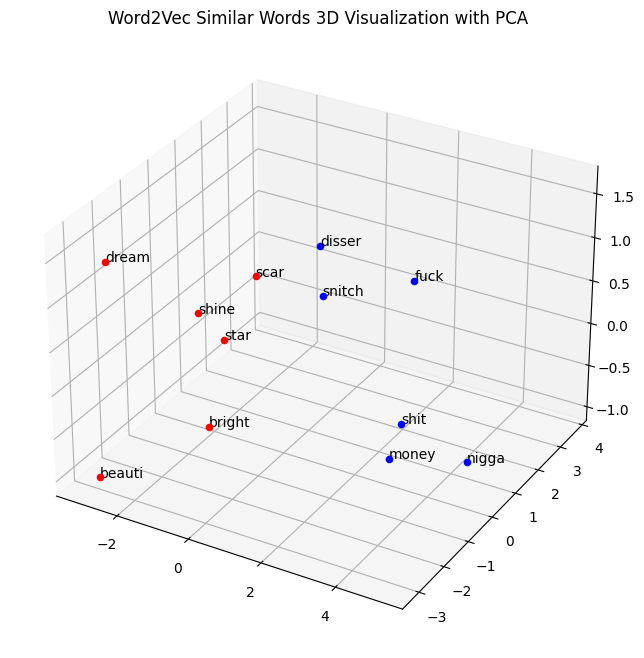

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # This is important for 3D plotting

# Find most similar words to 'beauti' and 'nigga'
similar_words_love = [w[0] for w in word2vec_model.wv.most_similar('beauti', topn=5)]
similar_words_nigga = [w[0] for w in word2vec_model.wv.most_similar('nigga', topn=5)]

# Combine the words and add 'beauti' and 'nigga' to the list
all_words = similar_words_love + ['beauti'] + similar_words_nigga + ['nigga']

# Extract vectors
all_word_vectors = np.array([word2vec_model.wv[word] for word in all_words])

# Reduce dimensions using PCA to 3 components
pca = PCA(n_components=3)
all_word_vectors_3d = pca.fit_transform(all_word_vectors)

# Plotting in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(all_words):
    ax.scatter(all_word_vectors_3d[i, 0], all_word_vectors_3d[i, 1], all_word_vectors_3d[i, 2],
               color='red' if word in similar_words_love or word == 'beauti' else 'blue')
    ax.text(all_word_vectors_3d[i, 0], all_word_vectors_3d[i, 1], all_word_vectors_3d[i, 2], word)

plt.title("Word2Vec Similar Words 3D Visualization with PCA")
plt.show()

In [68]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    return np.mean(word2vec_model.wv[doc], axis=0)

X_train_vec = np.array([document_vector(word2vec_model, doc) for doc in processed_train])
X_test_vec = np.array([document_vector(word2vec_model, doc) for doc in processed_test])

In [69]:
X_train_combined = np.concatenate([X_train_vec, X_train_num], axis=1)
X_test_combined = np.concatenate([X_test_vec, X_test_num], axis=1)

In [70]:
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import numpy as np
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(epochs=10, batch_size=32, optimizer="adam", learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(units=10, activation='relu', input_dim=X_train_combined.shape[1]),
        keras.layers.Dense(units=10, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax')
    ])

    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [71]:
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

hyperparams = {
    'epochs': [40,50],
    'batch_size': [64, 32],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.01, 0.001]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
grid = GridSearchCV(estimator=model, param_grid=hyperparams, cv=kfold, scoring='accuracy')
grid_result = grid.fit(X_train_combined, y_train)

# Stampa i risultati
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-71-08e11fed2709>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)


6/6 [==============================] - 0s 2ms/step
Best: 0.786678 using {'batch_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}


In [76]:
y_pred_nn = grid.predict(X_test_combined)

15/15 [==============================] - 0s 2ms/step


In [77]:
accuracy_score(y_test,y_pred_nn)

0.7789934354485777

In [ ]:
y_pred_nn = pd.DataFrame(y_pred_nn, columns=["Predictions"])
y_pred_nn.to_csv("y_pred_nn.csv", index=False)
files.download("y_pred_nn.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>